In [ ]:
# Library imports
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
import lightgbm as lgbm

!pip install catboost
from plotly.subplots import make_subplots
from sklearn import preprocessing, model_selection, linear_model, metrics, ensemble, inspection, feature_selection
from sklearn.model_selection import train_test_split as tts
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Aliases for specific functions
LabelEncoder = preprocessing.LabelEncoder
OneHotEncoder = preprocessing.OneHotEncoder
LinearRegression = linear_model.LinearRegression
PolynomialFeatures = preprocessing.PolynomialFeatures
RandomForestClassifier = ensemble.RandomForestClassifier
mean_squared_error = metrics.mean_squared_error
accuracy_score = metrics.accuracy_score
permutation_importance = inspection.permutation_importance
cross_val_score = model_selection.cross_val_score
RFE = feature_selection.RFE

In [ ]:
# Importing the datasets
continent_consumption = pd.read_csv('Continent_Consumption_TWH.csv')
country_consumption = pd.read_csv('Country_Consumption_TWH.csv')
non_renewable_generation = pd.read_csv('nonRenewablesTotalPowerGeneration.csv')
renewable_generation = pd.read_csv('renewablePowerGeneration97-17.csv')
top_countries_generation = pd.read_csv('top20CountriesPowerGeneration.csv')

print("Continent Consumption:")
print(continent_consumption.head())
print("\nCountry Consumption:")
print(country_consumption.head())
print("\nNon-Renewable Generation:")
print(non_renewable_generation.head())
print("\nRenewable Generation:")
print(renewable_generation.head())
print("\nTop Countries Generation:")
print(top_countries_generation.head())

Continent Consumption:
   Year      World      OECD     BRICS    Europe  North America  \
0  1990  101855.54  52602.49  26621.07  20654.88       24667.23   
1  1991  102483.56  53207.25  26434.99  20631.62       24841.68   
2  1992  102588.23  53788.75  25993.05  20189.68       25341.77   
3  1993  103646.56  54614.48  26283.80  20189.68       25830.23   
4  1994  104449.03  55579.77  25993.05  20085.01       26365.21   

   Latin America      Asia  Pacific   Africa  Middle-East       CIS  
0        5373.06  24574.19  1197.89  4407.77      2581.86  16049.40  
1        5500.99  24783.53  1186.26  4535.70      2744.68  15898.21  
2        5628.92  25690.67  1209.52  4582.22      3081.95  14339.79  
3        5675.44  26876.93  1267.67  4721.78      3349.44  13246.57  
4        5989.45  28098.08  1279.30  4803.19      3640.19  11606.74  

Country Consumption:
     Year  China  United States  Brazil  Belgium  Czechia  France  Germany  \
0  1990.0  874.0         1910.0   141.0     48.0     5

In [ ]:
# Using a loop through each dataframe, performing EDA and checking for missing values
dataframes = [continent_consumption, country_consumption, non_renewable_generation, renewable_generation, top_countries_generation]
names = ['Continent Consumption', 'Country Consumption', 'Non-renewable Generation', 'Renewable Generation', 'Top Countries Generation']

for df, name in zip(dataframes, names):
    print(f"Exploratory Data Analysis for {name} Data")
    print(df.head())
    print(df.info())
    print(df.describe())
    print("\n")
    print(f"Missing values in {name} Data")
    print(df.isnull().sum())
    print("\n")

print(country_consumption.columns)

Exploratory Data Analysis for Continent Consumption Data
   Year      World      OECD     BRICS    Europe  North America  \
0  1990  101855.54  52602.49  26621.07  20654.88       24667.23   
1  1991  102483.56  53207.25  26434.99  20631.62       24841.68   
2  1992  102588.23  53788.75  25993.05  20189.68       25341.77   
3  1993  103646.56  54614.48  26283.80  20189.68       25830.23   
4  1994  104449.03  55579.77  25993.05  20085.01       26365.21   

   Latin America      Asia  Pacific   Africa  Middle-East       CIS  
0        5373.06  24574.19  1197.89  4407.77      2581.86  16049.40  
1        5500.99  24783.53  1186.26  4535.70      2744.68  15898.21  
2        5628.92  25690.67  1209.52  4582.22      3081.95  14339.79  
3        5675.44  26876.93  1267.67  4721.78      3349.44  13246.57  
4        5989.45  28098.08  1279.30  4803.19      3640.19  11606.74  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 12 columns):
 #   Column      

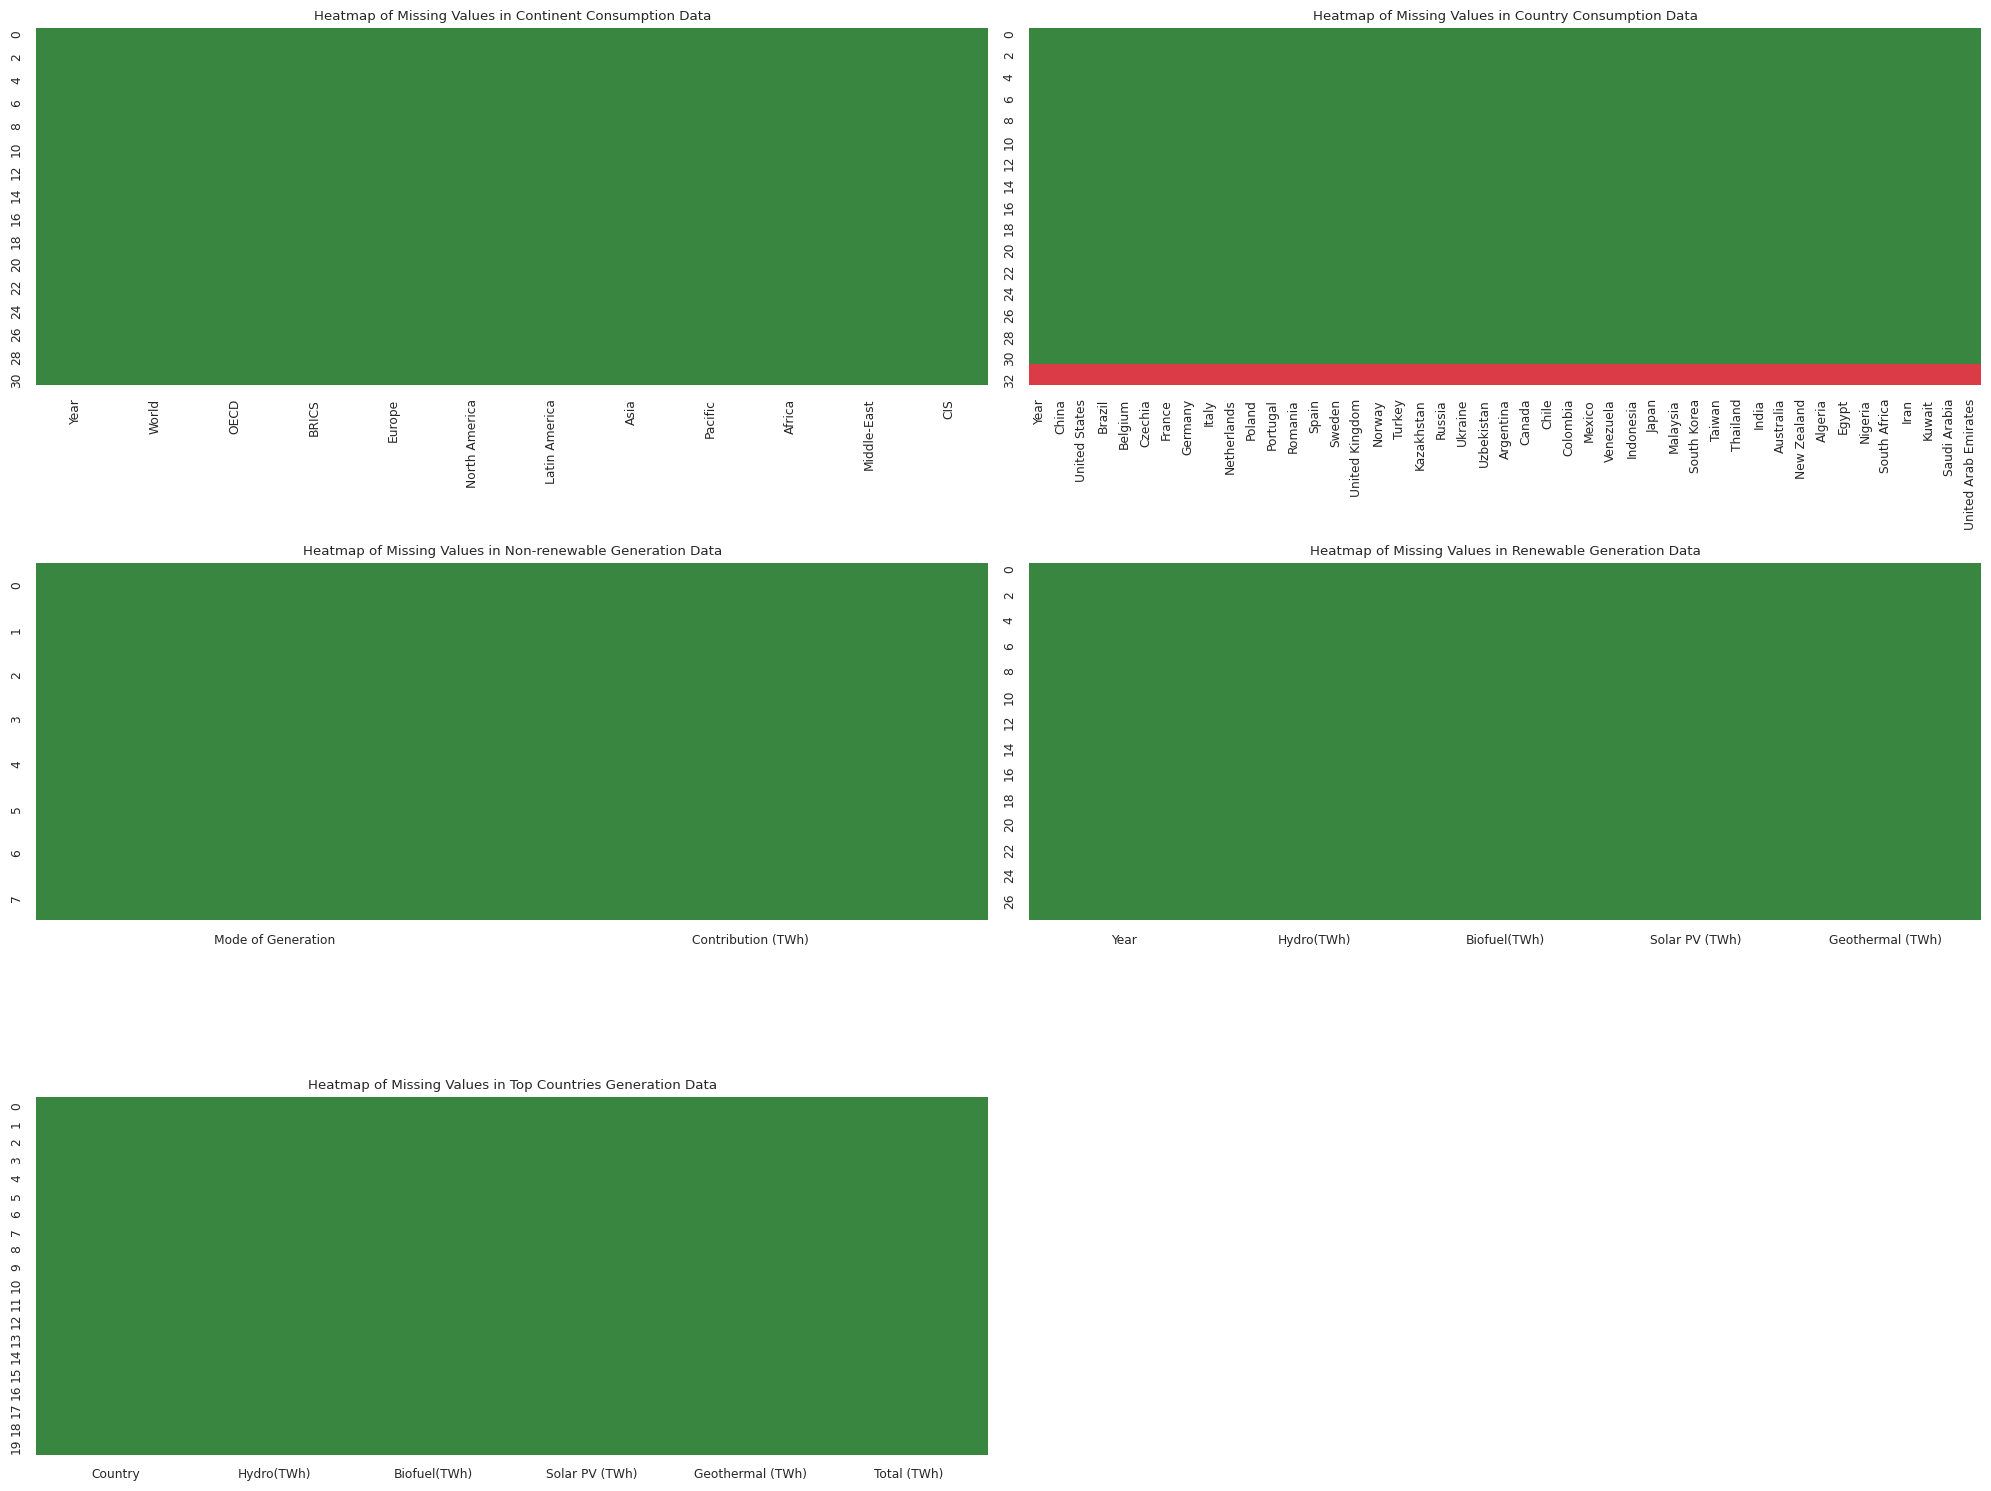

In [ ]:
# Visualise missing data
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

# Determine the number of dataframes
n = len(dataframes)

# Calculate the number of rows needed for the subplots
rows = math.ceil(n / 2)

# Create a figure and axes with 'rows' number of rows and 2 columns
fig, axs = plt.subplots(rows, 2, figsize=(20, 5 * rows))

# Flatten the axes array in case there's only one row
axs = axs.flatten()

# Create a custom color map
cmap = sns.diverging_palette(130, 10, as_cmap=True)  # Swapped the hue values

# Visualise missing data
for i, (df, name) in enumerate(zip(dataframes, names)):
    sns.heatmap(df.isnull(), cbar=False, cmap=cmap, ax=axs[i])
    axs[i].set_title(f'Heatmap of Missing Values in {name} Data')

# Remove any unused subplots
if n % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()




In [ ]:
# Create a dictionary with country-group mappings
country_to_group = {
    'OECD': ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'South Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States'],
    'BRICS': ['Brazil', 'Russia', 'India', 'China', 'South Africa'],
    'CIS': ['Armenia', 'Azerbaijan', 'Belarus', 'Kazakhstan', 'Kyrgyzstan', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Uzbekistan']
}

In [ ]:
# Flatten the dictionary to a list of tuples and create a DataFrame
mapping = pd.DataFrame([(country, group) for group, countries in country_to_group.items() for country in countries], columns=['Country', 'Group'])

# Reshape the DataFrames from wide to long format, merge the mapping with the reshaped country, group by 'Group'
country_consumption_long = country_consumption.melt(id_vars='Year', var_name='Country', value_name='Consumption')
top_countries_generation_long = top_countries_generation.melt(id_vars='Country', var_name='Mode of Generation', value_name='Generation')

merged_country_consumption = pd.merge(country_consumption_long, mapping, on='Country', how='left')
merged_top_countries_generation = pd.merge(top_countries_generation_long, mapping, on='Country', how='left')

grouped_country_consumption = merged_country_consumption.groupby(['Year', 'Group'])['Consumption'].sum().reset_index()
grouped_top_countries_generation = merged_top_countries_generation.groupby(['Country', 'Group', 'Mode of Generation'])['Generation'].sum().reset_index()

continent_data = continent_consumption.drop(['CIS','BRICS','OECD','Year'], axis=1)
cont_total = pd.DataFrame(continent_data.sum()).reset_index()
cont_total.columns = ['CONTINENT', 'Total Energy consumption (1990-2020)']

group_data = continent_consumption[['Year','CIS','BRICS','OECD','World']]
groups_total = pd.DataFrame(group_data.sum()).reset_index().drop(0)
groups_total.columns = ['GROUP', 'Total Energy consumption (1990-2020)']

In [ ]:
# Create a line plot for each group
fig = go.Figure()

for group in grouped_country_consumption['Group'].unique():
    group_data = grouped_country_consumption[grouped_country_consumption['Group'] == group]
    fig.add_trace(go.Scatter(x=group_data['Year'], y=group_data['Consumption'], mode='lines+markers', name=group))

fig.update_layout(
    title={
        'text': 'Energy Consumption: Group Wise',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    title_font=dict(
        size=20,
        color='rgb(107, 107, 107)',
        family='Arial, sans-serif'
    ),
    xaxis_title='Year',
    yaxis_title='Energy Consumption (TWh)',
    hovermode='x',
    paper_bgcolor='aliceblue'
)

fig.show()

In [ ]:
# Creating a line plot for each continent
fig = go.Figure()

for continent in continent_consumption.columns:
    if continent not in ['Year', 'CIS', 'BRICS', 'OECD', 'World']:
        fig.add_trace(go.Scatter(x=continent_consumption['Year'], y=continent_consumption[continent], mode='lines+markers', name=continent))

fig.update_layout(
    title={
        'text': 'Energy Consumption: Continent Wise',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    title_font=dict(
        size=20,
        color='rgb(107, 107, 107)',
        family='Arial, sans-serif'
    ),
    xaxis_title='Year',
    yaxis_title='Energy Consumption (TWh)',
    hovermode='x',
    paper_bgcolor='aliceblue'
)

fig.show()

In [ ]:
# Energy consumption over time for different energy sources

Energy_Sources = ['Hydro(TWh)', 'Biofuel(TWh)', 'Solar PV (TWh)', 'Geothermal (TWh)']

fig = go.Figure()

for source in Energy_Sources:
    fig.add_trace(go.Scatter(
        x=renewable_generation['Year'],
        y=renewable_generation[source],
        mode='lines',
        stackgroup='one',
        name=source
    ))

    fig.update_layout(
    title={
        'text': 'Stacked Area Chart: Energy Consumption Over Time',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    title_font=dict(
        size=20,
        color='rgb(107, 107, 107)',
        family='Arial, sans-serif'
    ),
    xaxis_title='Year',
    yaxis_title='Energy Consumption (TWh)',
    hovermode='x',
    paper_bgcolor='aliceblue'
)

fig.show()

        Hydro(TWh)  Biofuel(TWh)  Solar PV (TWh)  Geothermal (TWh)
count    28.000000     28.000000       28.000000         28.000000
mean   2974.167500    245.032500       57.430000         57.014286
std     595.936814    329.275399      113.343588         14.850555
min    2191.670000      3.880000        0.090000         36.420000
25%    2598.630000     11.422500        0.257500         42.330000
50%    2718.725000     74.330000        2.335000         55.295000
75%    3298.897500    365.037500       40.105000         68.397500
max    4197.290000   1127.310000      443.550000         85.340000


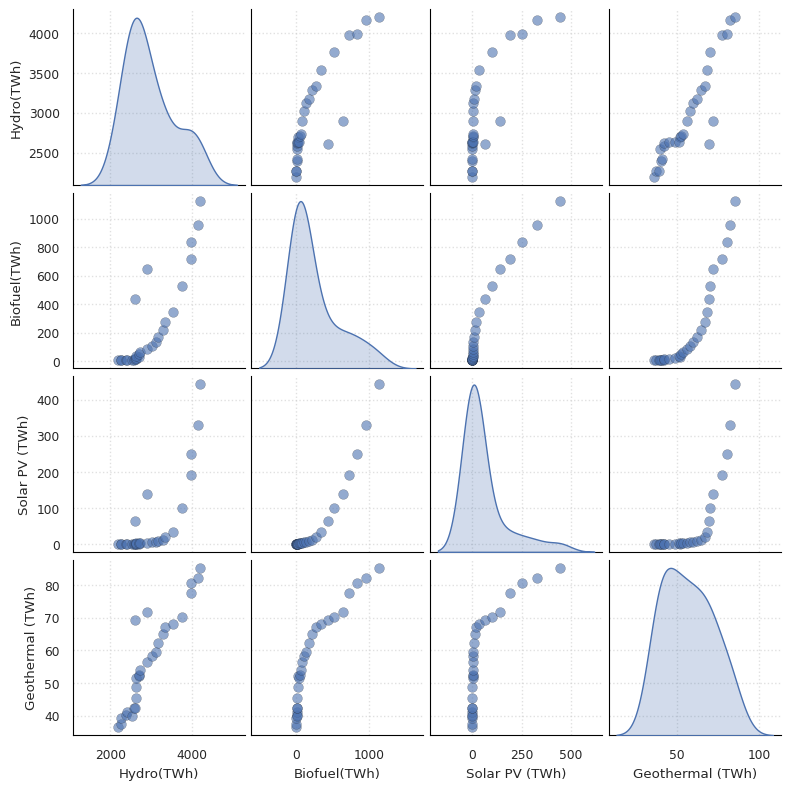

In [ ]:
# Scatter Plot Matrix of Energy Sources
energy_sources = renewable_generation[['Hydro(TWh)', 'Biofuel(TWh)', 'Solar PV (TWh)', 'Geothermal (TWh)']]

print(energy_sources.describe())
sns.set(style='whitegrid', font_scale=0.8)

scatter_plot_matrix = sns.pairplot(energy_sources, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 50, 'edgecolor': 'k', 'linewidths': 0.2}, height=2)
for ax in scatter_plot_matrix.axes.flatten():
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.grid(True, linestyle=':', alpha=0.6)

plt.show()


In [ ]:
# Creating donut charts
cont_total = cont_total[cont_total['CONTINENT'] != 'World']
groups_total = groups_total[groups_total['GROUP'] != 'World']

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=cont_total['CONTINENT'], values=cont_total['Total Energy consumption (1990-2020)'], textinfo='label+percent'), 1, 1)
fig.add_trace(go.Pie(labels=groups_total['GROUP'], values=groups_total['Total Energy consumption (1990-2020)'], textinfo='label+percent'), 1, 2)

fig.update_traces(hole=.4, hoverinfo="label+percent+value")

fig.update_layout(
    title_text="ENERGY CONSUMPTION TOTALS: 1990 TO 2020",
    annotations=[dict(text='Continent-Wise', x=0.15, y=1.1, font_size=17, showarrow=False),
                 dict(text='Group-Wise', x=0.83, y=1.1, font_size=17, showarrow=False)],
    autosize=False,width=1200, height=500, paper_bgcolor="aliceblue",
    title_font_size=20, title_font_family='Arial Bold',
    margin=dict(l=50, r=50, b=100, t=100, pad=4, autoexpand=True),
    title_x=0.5, title_y=0.95
)

fig.update_layout(shapes=[
    dict(type="rect",
         xref="paper", yref="paper",
         x0=-0.15, x1=1.235, y0=-0.32, y1=1.32,
         line=dict(color="black", width=2),
         fillcolor=None),
     dict(type="rect",
         xref="paper", yref="paper",
         x0=-0.6, x1=1.6, y0=1.15, y1=1.32,
         fillcolor="blanchedAlmond",
         layer="below",
         line_width=3,line_color='navy')
])

fig.show()



In [ ]:
# Checking for outliers in the 'Hydro(TWh)' column of the 'renewable_generation' DataFrame
column = 'Hydro(TWh)'
dataframe = renewable_generation
z_scores = np.abs(stats.zscore(dataframe[column]))

outliers = np.where(z_scores > 3)

print(f"Outliers in {column} column:")
print(dataframe.iloc[outliers])

Outliers in Hydro(TWh) column:
Empty DataFrame
Columns: [Year, Hydro(TWh), Biofuel(TWh), Solar PV (TWh), Geothermal (TWh)]
Index: []


In [ ]:
# Calculate the year-on-year change in energy consumption
for column in ['Hydro(TWh)', 'Biofuel(TWh)', 'Solar PV (TWh)', 'Geothermal (TWh)']:
    renewable_generation[column + '_change'] = renewable_generation[column].diff()

In [ ]:
# Calculate the total renewable energy generation by summing the energy generated from Hydro, Biofuel, Solar PV, and Geothermal sources.
renewable_generation['total_renewable'] = renewable_generation[['Hydro(TWh)', 'Biofuel(TWh)', 'Solar PV (TWh)', 'Geothermal (TWh)']].sum(axis=1)

# Calculate the total non-renewable energy generation and add the total non-renewable energy generation to the renewable generation Dataframe, and then calculate the ratio of total renewable energy to total non-renewable energy
total_non_renewable = non_renewable_generation['Contribution (TWh)'].sum()
renewable_generation['total_non_renewable'] = total_non_renewable
renewable_generation['renewable_to_non_renewable_ratio'] = renewable_generation['total_renewable'] / renewable_generation['total_non_renewable']

In [ ]:
non_renewable_generation.head()

,Mode of Generation,Contribution (TWh)
0,Coal,9863.33
1,Natural Gas,5882.82
2,Nuclear,2636.03
3,Oil,841.87
4,Waste,114.04


from matplotlib import pyplot as plt
_df_0['Contribution (TWh)'].plot(kind='hist', bins=20, title='Contribution (TWh)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Mode of Generation').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Contribution (TWh)'].plot(kind='line', figsize=(8, 4), title='Contribution (TWh)')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['Mode of Generation'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='Contribution (TWh)', y='Mode of Generation', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Model to predict renewable_to_non_renewable_ratio
X = renewable_generation.drop('renewable_to_non_renewable_ratio', axis=1)
y = renewable_generation['renewable_to_non_renewable_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
X_test = X_test.dropna()

In [ ]:
# Drop NaNs and make predictions
X_test = X_test.dropna()
y_pred = model.predict(X_test)

In [ ]:
# Calculate MAE
y_test = y_test[X_test.index]
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.003515162359832505


In [ ]:
# Get and sort feature importances
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

print(feature_importances)

                    Feature  Importance
1                Hydro(TWh)    0.229211
9           total_renewable    0.157765
3            Solar PV (TWh)    0.119415
0                      Year    0.102503
2              Biofuel(TWh)    0.093833
7     Solar PV (TWh)_change    0.088242
6       Biofuel(TWh)_change    0.083449
4          Geothermal (TWh)    0.078853
5         Hydro(TWh)_change    0.036603
8   Geothermal (TWh)_change    0.010126
10      total_non_renewable    0.000000


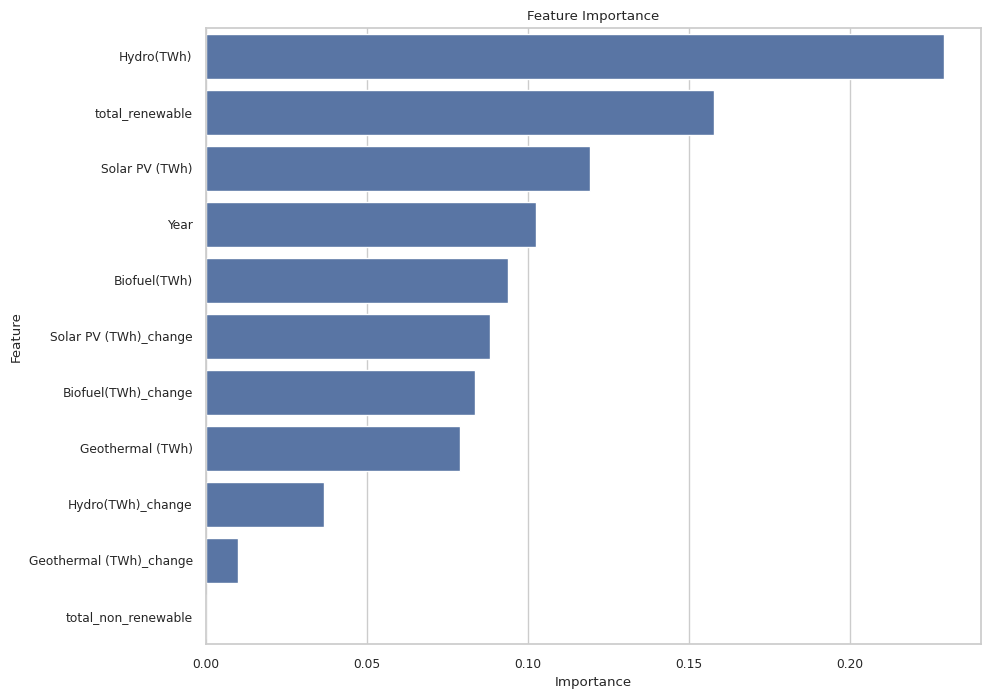

In [ ]:
# Visualize feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances, x='Importance', y='Feature', color='b')
plt.title('Feature Importance')
plt.show()
